In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

### 1. Data Loading & Exploration

In [2]:
wastewater = pd.read_csv("data/Data-Melbourne_F_Fixed.csv")

### 2. Data Visualization

In [3]:
# call info on data, head, and null counts
wastewater.head()

Unnamed: 0  Average Outflow  Average Inflow  Energy Consumption  Ammonia  \
0           0            2.941           2.589            175856.0     27.0   
1           1            2.936           2.961            181624.0     25.0   
2           2            2.928           3.225            202016.0     42.0   
3           3            2.928           3.354            207547.0     36.0   
4           4            2.917           3.794            202824.0     46.0   

   Biological Oxygen Demand  Chemical Oxygen Demand  Total Nitrogen  \
0                     365.0                   730.0          60.378   
1                     370.0                   740.0          60.026   
2                     418.0                   836.0          64.522   
3                     430.0                   850.0          63.000   
4                     508.0                  1016.0          65.590   

   Average Temperature  Maximum temperature  Minimum temperature  \
0                 19.3                 25.1                 12.6   
1                 17.1                 23.6                 12.3   
2                 16.8                 27.2                  8.8   
3                 14.6                 19.9                 11.1   
4                 13.4                 19.1                  8.0   

   Atmospheric pressure  Average humidity  Total rainfall  Average visibility  \
0                   0.0              56.0            1.52                10.0   
1                   0.0              63.0            0.00                10.0   
2                   0.0              47.0            0.25                10.0   
3                   0.0              49.0            0.00                10.0   
4                   0.0              65.0            0.00                10.0   

   Average wind speed  Maximum wind speed    Year  Month  Day  
0                26.9                53.5  2014.0    1.0  1.0  
1                14.4                27.8  2014.0    1.0  2.0  
2                31.9                61.1  2014.0    1.0  5.0  
3                27.0                38.9  2014.0    1.0  6.0  
4                20.6                35.2  2014.0    1.0  7.0

In [4]:
wastewater.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1382 non-null   int64  
 1   Average Outflow           1382 non-null   float64
 2   Average Inflow            1382 non-null   float64
 3   Energy Consumption        1382 non-null   float64
 4   Ammonia                   1382 non-null   float64
 5   Biological Oxygen Demand  1382 non-null   float64
 6   Chemical Oxygen Demand    1382 non-null   float64
 7   Total Nitrogen            1382 non-null   float64
 8   Average Temperature       1382 non-null   float64
 9   Maximum temperature       1382 non-null   float64
 10  Minimum temperature       1382 non-null   float64
 11  Atmospheric pressure      1382 non-null   float64
 12  Average humidity          1382 non-null   float64
 13  Total rainfall            1382 non-null   float64
 14  Average 

In [5]:
print(wastewater.isnull().sum())

Unnamed: 0                  0
Average Outflow             0
Average Inflow              0
Energy Consumption          0
Ammonia                     0
Biological Oxygen Demand    0
Chemical Oxygen Demand      0
Total Nitrogen              0
Average Temperature         0
Maximum temperature         0
Minimum temperature         0
Atmospheric pressure        0
Average humidity            0
Total rainfall              0
Average visibility          0
Average wind speed          0
Maximum wind speed          0
Year                        0
Month                       0
Day                         0
dtype: int64


### 3. Data Preprocessing

In [6]:
# handle missing values - replace zero vals with NaN, then fill with median
# not applicable to this dataset

# grab data from df
features = [
    "Ammonia",
    "Biological Oxygen Demand",
    "Chemical Oxygen Demand",
    "Total Nitrogen",
    "Average Temperature",
    "Maximum temperature",
    "Minimum temperature",
]
X = pd.DataFrame(wastewater[features])

# X = pd.DataFrame(wastewater.iloc[:, :-1])

# standardize data before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [7]:
# use clustering to create target variable: microbial activity
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
wastewater["cluster"] = clusters

cluster_profiles = wastewater.groupby("cluster")[features].mean()
print(cluster_profiles)

wastewater["microbial_activity_label"] = wastewater["cluster"].apply(
    lambda x: "high" if x == 1 else "medium" if x == 0 else "low"
)

y = wastewater["microbial_activity_label"]

           Ammonia  Biological Oxygen Demand  Chemical Oxygen Demand  \
cluster                                                                
0        40.139434                382.832593              847.612810   
1        35.762977                335.605830              751.051274   
2        42.607407                440.605679              965.477728   

         Total Nitrogen  Average Temperature  Maximum temperature  \
cluster                                                             
0             63.655793            21.033333            28.312854   
1             60.220459            11.252703            15.728571   
2             64.927190            13.080247            17.853580   

         Minimum temperature  
cluster                       
0                  14.793028  
1                   6.958108  
2                   8.585926  


c:\Users\dorky\anaconda3\envs\AD_450_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


### 4. Dimensionality Reduction

In [8]:
# use PCA to reduce dimensions to a max of 5 principal components
pca = PCA(n_components=5)
pca_X = pca.fit_transform(X_scaled)

# print explained variance ratio of components used
print(pca.explained_variance_ratio_)

[0.43721493 0.28019609 0.12356658 0.07770374 0.0414442 ]


<Axes: >

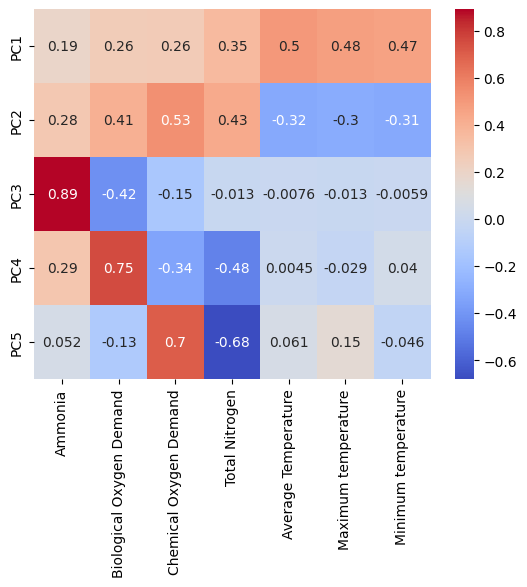

In [9]:
# heatmap of feature importance in PCA components
loadings = pd.DataFrame(pca.components_, columns=X_scaled_df.columns)
sbn.heatmap(
    loadings,
    annot=True,
    cmap="coolwarm",
    xticklabels=X_scaled_df.columns,
    yticklabels=[f"PC{i+1}" for i in range(loadings.shape[0])],
)

### 5. Train-Test Split & Class Balancing

In [10]:
# split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# use SMOTE to oversample minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### 6. Model Training & Cross-Validation

In [11]:
# K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Naive Bayes
nb = GaussianNB()

# Logistic Regression
lgr = LogisticRegression()

# Decision Trees
dtc = DecisionTreeClassifier()

# Support Vector Machines
svm = SVC(probability=True)

### 7. Model Evaluation & Reporting

In [12]:
import time

def timing_decorator(method):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = method(*args, **kwargs)
        end = time.time()
        print(f"Execution time: {end - start:.2f} seconds \n")
        return result
    return wrapper 

In [15]:
@timing_decorator
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, np.ravel(y_train))
    y_pred = model.predict(X_test)

    cf = confusion_matrix(y_test, y_pred)
    accuracy = model.score(X_test, y_test)
    scores = classification_report(y_test, y_pred, output_dict=True)

    cv_scores = cross_validate(model, X_test, y_test, cv=5, scoring="accuracy")

    print(model, "Results")
    print("Confusion Matrix: \n", cf)

    print("Train Test Split Results:")
    print("Accuracy: ", accuracy)
    macro_avg = scores["macro avg"]
    print("Macro Average:")
    print(f"  Precision: {macro_avg['precision']:.3f}")
    print(f"  Recall:    {macro_avg['recall']:.3f}")
    print(f"  F1-Score:  {macro_avg['f1-score']:.3f}")

    print("Cross Validation Results:")
    print(f"Cross-validation Scores (5-fold): {cv_scores['test_score']}")
    print(f"CV Accuracy: {np.mean(cv_scores['test_score']):.3f}")
    print(f"CV STD: {np.std(cv_scores['test_score']):.3f}")
    print(f"{'='*40}\n")

In [16]:
# test and print results
models = [nb, lgr, dtc, svm, knn]

for model in models: 
    evaluate_model(model, X_resampled, y_resampled, X_test, y_test)

GaussianNB() Results
Confusion Matrix: 
 [[88  2  2]
 [ 5 88  3]
 [ 0  3 86]]
Train Test Split Results:
Accuracy:  0.9458483754512635
Macro Average:
  Precision: 0.946
  Recall:    0.946
  F1-Score:  0.946
Cross Validation Results:
Cross-validation Scores (5-fold): [0.91071429 0.94642857 0.94545455 0.98181818 0.94545455]
CV Accuracy: 0.946
CV STD: 0.022

Execution time: 0.07 seconds 

LogisticRegression() Results
Confusion Matrix: 
 [[90  2  0]
 [ 0 95  1]
 [ 0  1 88]]
Train Test Split Results:
Accuracy:  0.9855595667870036
Macro Average:
  Precision: 0.986
  Recall:    0.986
  F1-Score:  0.986
Cross Validation Results:
Cross-validation Scores (5-fold): [0.98214286 0.92857143 0.98181818 0.98181818 1.        ]
CV Accuracy: 0.975
CV STD: 0.024

Execution time: 0.10 seconds 

DecisionTreeClassifier() Results
Confusion Matrix: 
 [[80  6  6]
 [ 8 80  8]
 [ 5  2 82]]
Train Test Split Results:
Accuracy:  0.8736462093862816
Macro Average:
  Precision: 0.874
  Recall:    0.875
  F1-Score:  0.87

C:\Users\dorky\AppData\Local\Temp\ipykernel_10816\1740097269.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  count_plot.set_xticklabels(["Medium", "High", "Low"])


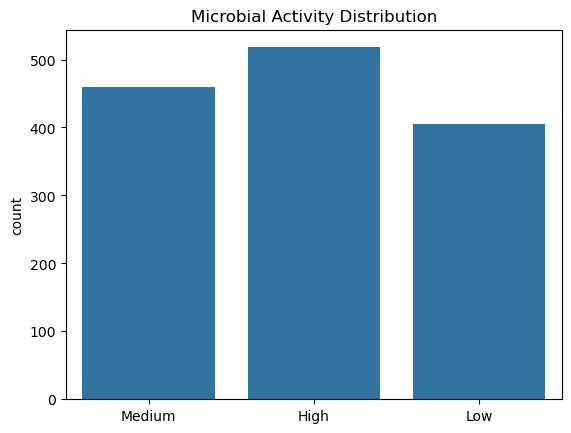

In [ ]:
# Class distribution count plot
count_plot = sbn.countplot(x=np.ravel(y))
count_plot.set_xticklabels(["Medium", "High", "Low"])
plt.title("Microbial Activity Distribution")
plt.show()

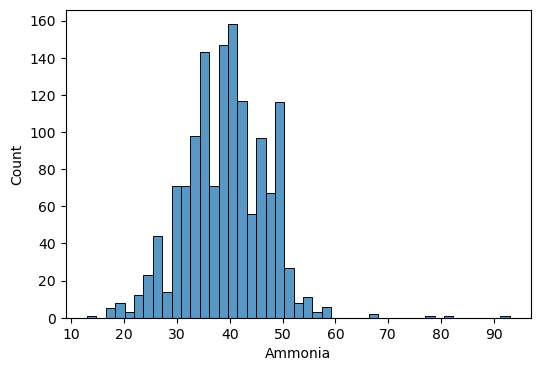

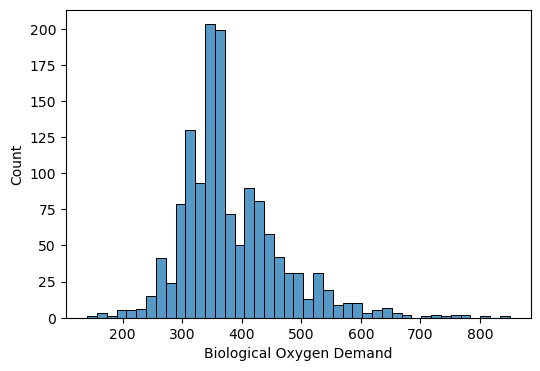

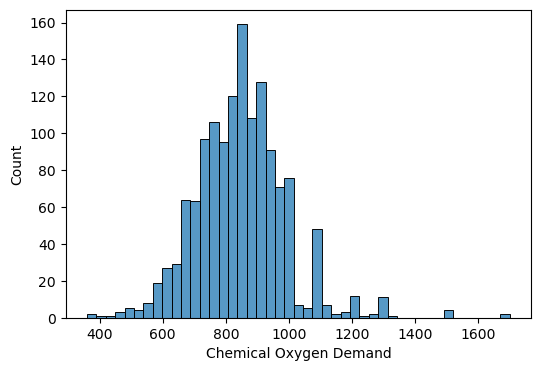

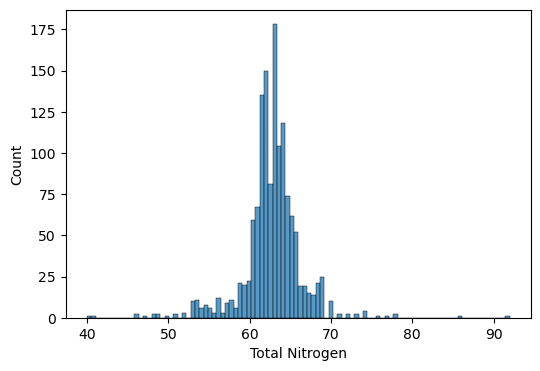

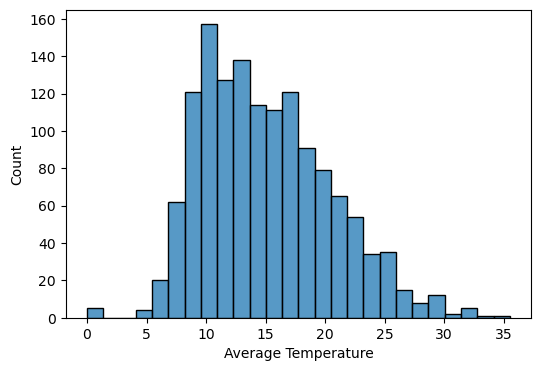

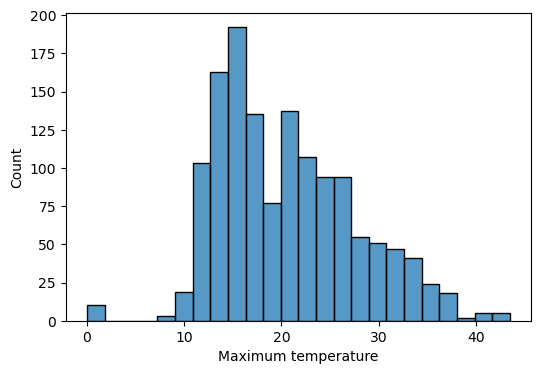

In [ ]:
# Histograms of feature distributions
for col in X.columns:
    plt.figure(figsize=(6, 4))
    sbn.histplot(X[col])

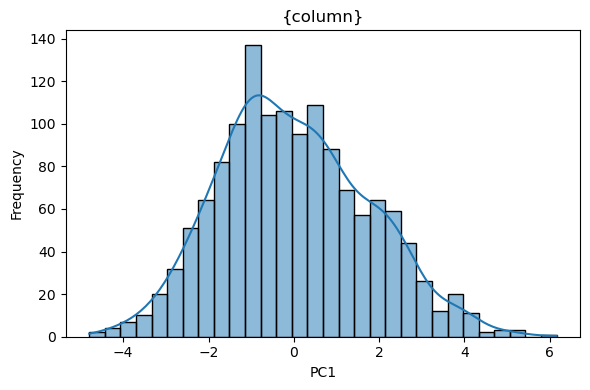

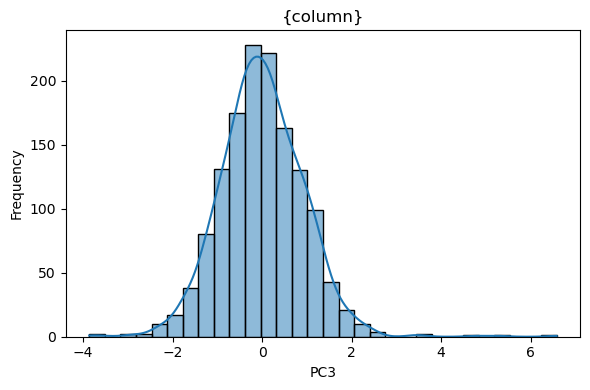

In [ ]:
# pca_hists = sbn.histplot(pca_X)
p_df = pd.DataFrame(pca_X, columns=[f"PC{i+1}" for i in range(pca_X.shape[1])])

for column in p_df.columns:
    plt.figure(figsize=(6, 4))
    sbn.histplot(p_df[column], bins=30, kde=True)
    plt.title("{column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

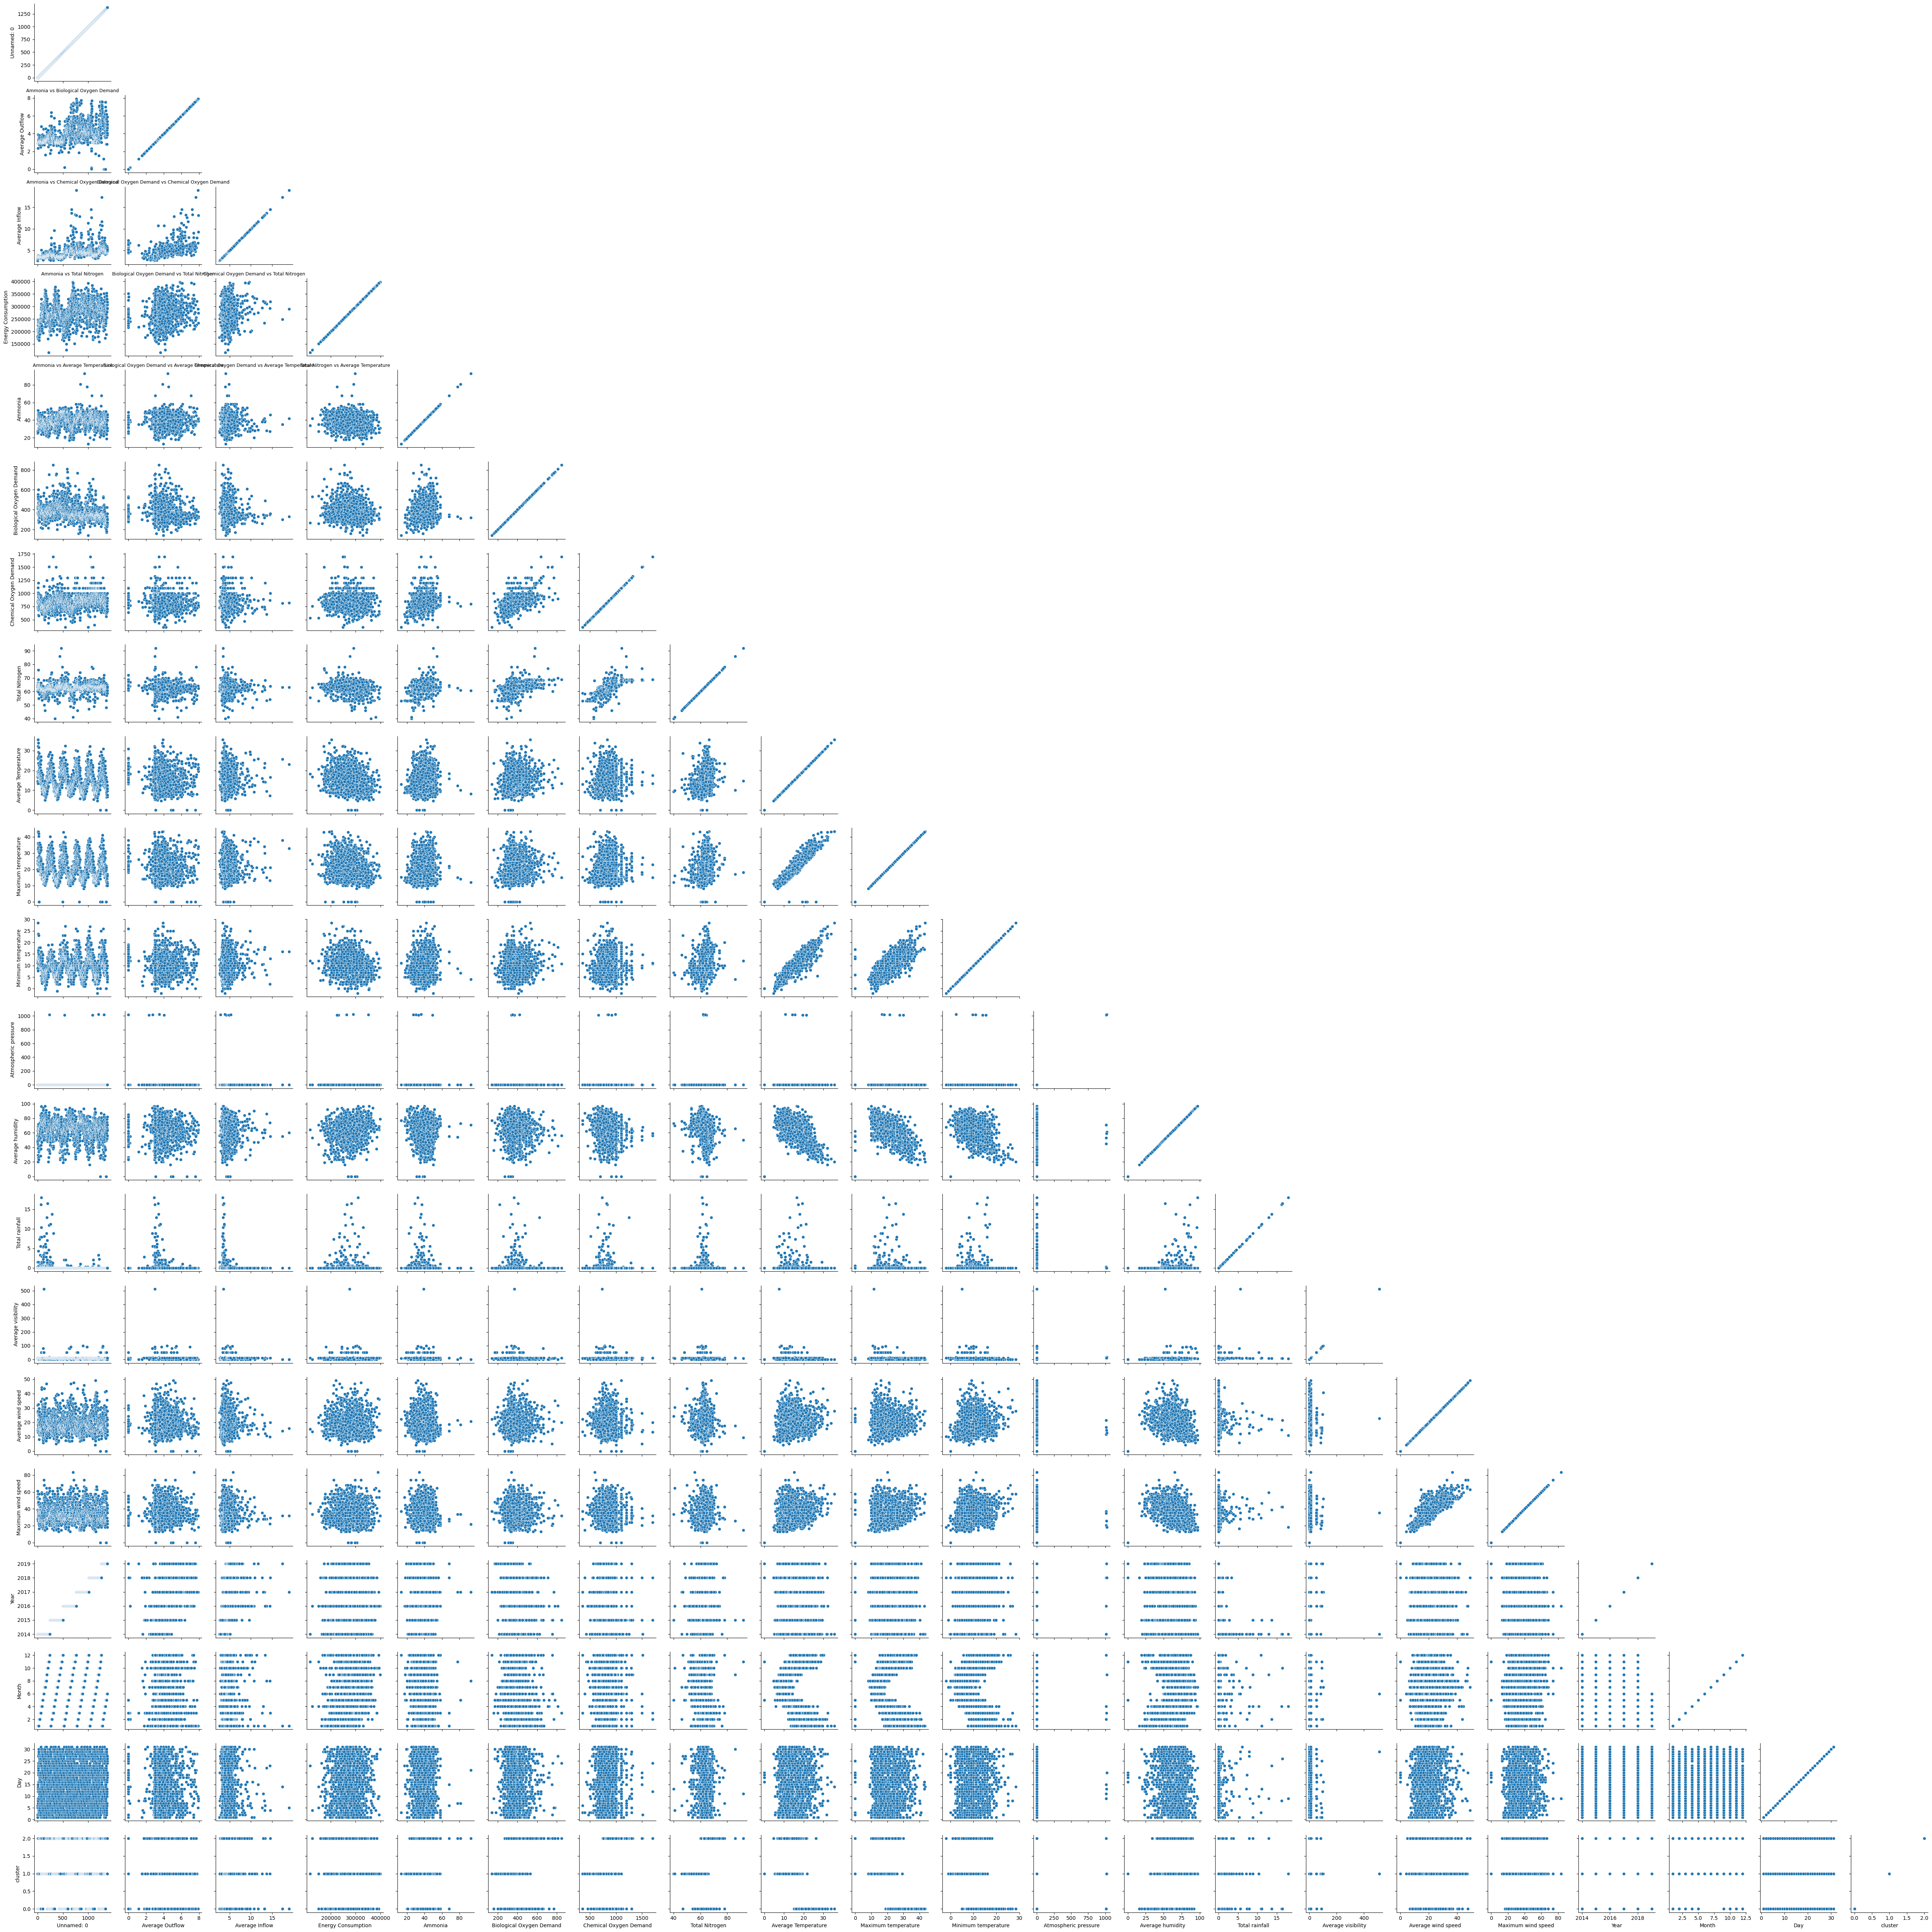

In [ ]:
# Pair plots for feature relationships
pairplots = sbn.pairplot(wastewater, diag_kind=None, corner=True)

selected_features = [
    "Ammonia",
    "Biological Oxygen Demand",
    "Chemical Oxygen Demand",
    "Total Nitrogen",
    "Average Temperature",
]

for i, row_var in enumerate(selected_features):
    for j, col_var in enumerate(selected_features):
        if j >= i:
            continue
        ax = pairplots.axes[i, j]
        ax.set_title(f"{col_var} vs {row_var}", fontsize=9)

plt.tight_layout()
plt.show()

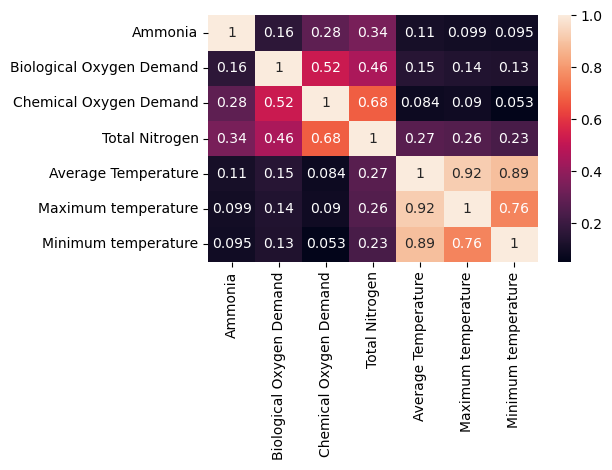

In [ ]:
# heat map of feature correlations
corr_matrix = X[features].corr()

sbn.heatmap(corr_matrix, annot=True)
plt.tight_layout()
plt.show()